In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.VAE import WideAE

In [2]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

## WideAE

In [6]:
encoderWide = nn.Sequential(nn.Linear(28 * 28, 256),
                            nn.ReLU(),
                            nn.Linear(256, 128),
                            nn.ReLU())
decoderWide = nn.Sequential(nn.Linear(128, 128),
                            nn.ReLU(),
                            nn.Linear(128, 256),
                            nn.ReLU(),
                            nn.Linear(256, 28 * 28),
                            nn.Sigmoid())

model = WideAE(encoderWide, decoderWide, 128, 16, 128).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [7]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output = model(data)
            loss = BCE(output, data)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            output = model(data)
            loss = BCE(output, data)
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest loss: {:.6f}'.format(
                epoch, loss.item()))
    return allLoss

In [8]:
for epoch in range(1, 201):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

 39%|███▉      | 23/59 [00:02<00:03, 11.11batch/s,  Epoch: 78 	Loss: 0.157627	 lr: 0.10000000]


KeyboardInterrupt: 

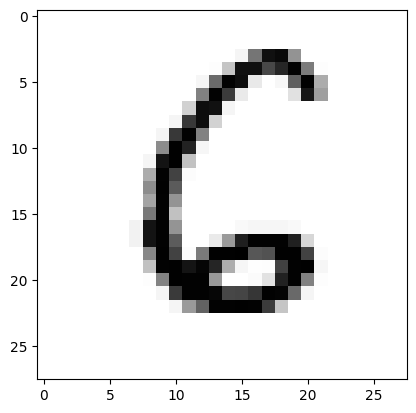

In [113]:
img0 = next(iter(test_loader))[0][98]
plt.imshow(img0[0], cmap='Greys')

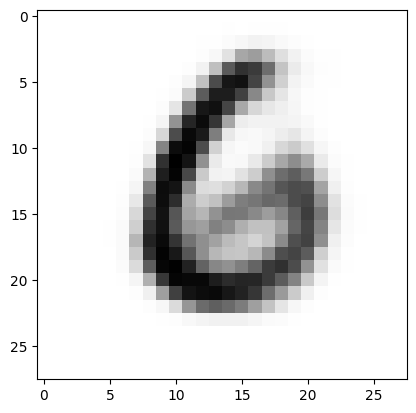

In [122]:
output = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

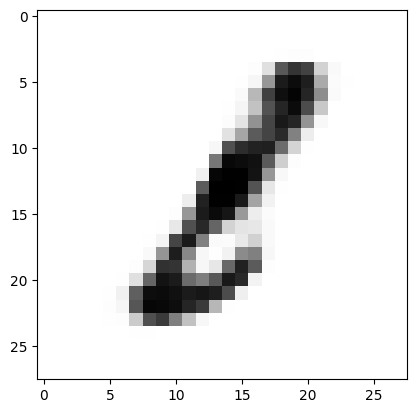

In [112]:
output = model.sample(3)
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

In [123]:
torch.save(model.state_dict(),'WideAE_small_linear_78epoch')